In [4]:
import os
from os.path import basename, dirname, join, exists
import sys
import time

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

# 1d so the smoothing is specific to each realization
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

import h5py


In [5]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')

flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 
import flopy.utils.binaryfile as bf


In [6]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'
tprogs_id = '_no_cond_c3d'


data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [7]:
nrow = 100
ncol = 230

In [8]:
setbacks = np.arange(0, 3400,200)
# smoothed XS data used for setback analysis
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv', index_col='dist_from_right_m')
num_segs = xs_levee_smooth.shape[1]

# load array identifying row,col to XS id (1,28)
xs_arr = np.loadtxt(chan_dir+'XS_num_grid_reference.tsv')

# load flood typology characteristics (based on daily data 1908 - 2014) - median values 
#"cms_pk" for peak discharge, "pk_loc" for time to peak, and "log_no_d" for duration
flood_type = pd.read_csv(join(box_dir, 'whipple_grp6_w97ftmedians.csv'),index_col='Group.1')


In [27]:
import h5py
f = h5py.File(join(chan_dir, 'setback_locs.hdf5'), "r")
local_str_setbacks = f['setbacks']['local'][:]
str_setbacks = f['setbacks']['regional'][:]

f.close()

In [9]:

def load_output(ft_in, region):
    tic = time.time()
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
    rch_hf_all = np.zeros((100, len(setbacks),nrow,ncol))
    Q_all = np.zeros((100, T_in, len(setbacks),xs_levee_smooth.shape[1]+1))

    # filter out for only those realizations that successfully ran
    base_fn = join(data_dir, region, 'type'+str(ft_in))
    r_out = pd.Series(os.listdir(base_fn)).str.extract(r'(\d{3})')[0].unique().astype(int)
    # takes a 
    for t in r_out: # np.arange(0,100): #[0]:
        r_fn = join(base_fn,'r'+str(t).zfill(3)+'_')
        # saving all of the flow at all steps, setbacks is needed to post-process
        Q_in = np.loadtxt(r_fn+'flow.tsv')
        Q = np.reshape(Q_in, ((T_in, len(setbacks), xs_levee_smooth.shape[1]+1)))
        Q_all[t,:] = np.copy(Q)

        # for recharge we want to aggregate across time steps but look at differences across setbacks
        rch_in = np.loadtxt(r_fn+'recharge.tsv')
        rch_sum = np.reshape(rch_in, (len(setbacks), nrow, ncol))
        rch_hf_all[t] = np.copy(rch_sum)
    # convert to m3/day and will have the total recharged after summing individual days
    rch_hf_all = rch_hf_all*86400

    # convert to total AF from total m3
    # rch_hf_all = rch_hf_all/((0.3048**3)*43560)

    toc = time.time()
    print('Loading',region,'for flow type',str(ft_in), 'took %.2f minutes' %((toc-tic)/60))
    return(Q_all, rch_hf_all)

In [135]:

def load_hdf5_output(ft_in, region):
    tic = time.time()
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
    rch_hf_all = np.zeros((100, len(setbacks),nrow,ncol))
    Q_all = np.zeros((100, T_in, len(setbacks),xs_levee_smooth.shape[1]+1))
    d_all = np.zeros((100, T_in, len(setbacks),xs_levee_smooth.shape[1]))

    # filter out for only those realizations that successfully ran
    base_fn = join(data_dir, region, 'type'+str(ft_in))
    r_out = pd.Series(os.listdir(base_fn)).str.extract(r'(\d{3})')[0].unique().astype(int)
    # takes a 
    for t in r_out: # np.arange(0,100): #[0]:
        # load hdf5 files for each realization
        r_fn = join(base_fn,'r'+str(t).zfill(3)+'_')
        f = h5py.File(r_fn+'output.hdf5', "r")
        Q = f['array']['flow'][:]        
        rch_hf = f['array']['rch_hf'][:]
        # depth is a little complicated to summarize, not so bad to back it out from
        d_arr = f['array']['depth'][:]
        f.close()
        # saving all of the flow at all steps, setbacks is needed to post-process
        Q_all[t] = np.copy(Q)
        # sum recharge across time to save storage space (breaks python at 25GB)
        rch_hf = np.nansum(rch_hf, axis=0)
        rch_hf_all[t] = np.copy(rch_hf)
        # depth needs to be averaged across each segment
        for s in np.arange(0,len(setbacks)):
            for nseg in np.arange(0, num_segs):
                # mask zeros to not estimate depth based on zero values
                # could present as average positive depth or maximum
                d_out = d_arr[:,s, (xs_arr==nseg)&(str_setbacks[s].astype(bool))]
                d_all[t,:,s, nseg] =  ma.masked_where(d_out==0, d_out).mean()


    # convert to m3/day and will have the total recharged after summing individual days
    rch_hf_all = rch_hf_all*86400

    toc = time.time()
    print('Loading',region,'for flow type',str(ft_in), 'took %.2f minutes' %((toc-tic)/60))
    return(Q_all, rch_hf_all, d_all)

In [134]:
rch_hf_all.shape

(100, 34, 17, 100, 230)

In [116]:
ft_in=1
region='regional'
Q_all, rch_hf_all, d_all = load_hdf5_output(ft_in, region)


Loading regional for flow type 1 took 7.34 minutes


In [60]:
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)

In [108]:
d_seg = np.zeros((100, T_in, len(setbacks),xs_levee_smooth.shape[1]))

tic = time.time()

# takes .045 sec to extract nseg, should take about 5 sec
for t in np.arange(0,100):
    for s in np.arange(0,len(setbacks)):
        for nseg in np.arange(0, num_segs):
            # mask zeros to not estimate depth based on zero values
            d_out = d_all[t,:,s, (xs_arr==nseg)&(str_setbacks[s].astype(bool))]
            d_seg[t,:,s, nseg] =  ma.masked_where(d_out==0, d_out).mean()
toc = time.time()
toc-tic

9.360796689987183

## Save files as hdf5 to save time with reloading
For each region and flow type save an hdf5 file that will include all realizations, so when reloading it takes 1 second instead of minutes.

In [16]:
# ends up as about 500 MB, may want individual files

def arr_to_h5(arr, h5_fn):
    # convert arrays of annual etc to hdf5 files individually
    f = h5py.File(h5_fn, "w")
    grp = f.require_group('array') # makes sure group exists
    grp.attrs['units'] = 'cubic meters per day'
    grp.attrs['description'] = 'Each layer of the array is a day in the triangular hydrograph'
    dset = grp.require_dataset('all', arr.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = arr
    f.close()


This code only needs to be re-run when the models are rerun.

In [18]:
recreate_hdf5 = True
# recreate_hdf5 = False

In [136]:
if recreate_hdf5:
    for region in ['regional']: #['local_1','local_2','local_3']: # 'regional'
        for ft_in in [1,2,3]:
#             Q_all, rch_hf_all = load_output(ft_in, region)
            Q_all, rch_hf_all, d_all = load_hdf5_output(ft_in, region)

            arr_to_h5(Q_all, join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'))
            arr_to_h5(rch_hf_all, join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'))
            arr_to_h5(d_all, join(data_dir,'hdf5', 'all_depth_'+region+'_type'+str(ft_in)+'.hdf5'))

else:
    print('Reusing existing recharge and flow hdf5 files')

Loading regional for flow type 1 took 4.98 minutes
Loading regional for flow type 2 took 2.92 minutes
Loading regional for flow type 3 took 1.91 minutes


In [261]:
d_all[0, tp_in,10,:]

array([0.22907707, 0.25202421, 0.08871362, 0.21812969, 0.04859184,
       0.04211246, 0.03566391, 0.20460866, 0.14018821, 0.2257745 ,
       0.06616085, 0.18788733, 0.15080191, 0.20851759, 0.18617662,
       0.14892369, 0.17516988, 0.0343284 , 0.06327337, 0.26243325,
       0.0974729 , 0.32030669, 0.03054067, 0.05879134, 0.37009874,
       0.03669106, 0.0416166 , 0.01403146])

## Calculate depth
Depth is not directly saved as an output file, but can be calculated using the rating curve tables. This can be saved as an hdf file as well.

In [264]:
# rating curves for each segment and setback
xs_flow_all = pd.read_csv(join(chan_dir,'all_xs_50pt_rating_curves.csv'))

def depth_match(seg_flow, flow):
    """ Given a XS (nseg, setback) return the expected depth (m) given a flow (cms)"""
    # find flows above and below the input flow
    flow_diff = (seg_flow.flow_cms-flow)
    f_high = flow_diff[flow_diff>0].argsort().index[0]
    f_low = flow_diff[flow_diff<0].argsort().index[-1]
    match_d = seg_flow.loc[[f_low, f_high]].sort_values('flow_cms')
    # linearly interpolate to calculate exact depth
    flow_slope = (match_d.iloc[1].flow_cms-match_d.iloc[0].flow_cms)/(match_d.iloc[1].depth_m-match_d.iloc[0].depth_m)
    out_depth = match_d.iloc[0].depth_m + (flow-match_d.iloc[0].flow_cms)/flow_slope
    return(out_depth)

In [269]:
d_arr = np.zeros(Q_all.shape)

# for s, setback in enumerate(setbacks):
r=0
s=5
setback=1000
t = tp_in
for nseg in np.arange(0,num_segs):
    seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
    if Q_all[r,t, s, nseg] >=seg_flow.flow_cms.min():
        d_arr[r,t, s, nseg] = depth_match(seg_flow, flow=Q_all[r,t, s, nseg])
    else:
        d_arr[r,t, s, nseg] = 0

In [270]:
# # this method is slightly different than the depth from the output because here
# the depth from the XS is given vs the depth above the raster
# this method which back calculates the depth given the flow
# returns the maximum depth for each segment which is what fish would likely have access to??
if recreate_hdf5:
    t0 = time.time()
    region = 'regional'
    for ft_in in [1,2,3]:
        f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
        Q_all = f['array']['all'][:]
        f.close()
        d_arr = np.zeros(Q_all.shape)
        # iterate over realizations
        for r in np.arange(Q_all.shape[0]):
            # days of flow
            for t in np.arange(0, Q_all.shape[1]):
                # setbacks
                for s, setback in enumerate(setbacks):
                    # segments
                    for nseg in np.arange(0,num_segs):
                        seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
                        if Q_all[r,t, s, nseg] >=seg_flow.flow_cms.min():
                            d_arr[r,t, s, nseg] = depth_match(seg_flow, flow=Q_all[r,t, s, nseg])
                        else:
                            d_arr[r,t, s, nseg] = 0
        # save to hdf5 file for each flow type
        arr_to_h5(d_arr, join(data_dir,'hdf5', 'peak_flow_xs_depth_'+region+'_type'+str(ft_in)+'.hdf5'))

    # output will be all depths
    t1 = time.time()
    # 6.7 seconds for 1 realization, ~10 min for 100 x 3 flood types is ~30 min
    # the shortest flow type probably only took 10 min, the others are like 5-10x longer
    # seems to take longer than 30 min because it took 2 hrs in total
    print((t1-t0)/60)
else:
    print('Reusing existing recharge and flow hdf5 files')

129.206416285038


# Load joint array data back in
Now each file can be reloading easily by specifying region and flow type.

In [140]:
ft_plt = [1,2,3]


## Check fo setback distances/realizations that violate the minimum in-stream flow

In [119]:
region='regional'
ft_in=2
f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
Q_all = f['array']['all'][:]
f.close()


In [120]:
# minimum in-stream flow is 180 cfs generally, it is slightly higher as one goes up stream as it is dependent
# on depth (1 foot for adults, 6 inches for juveniles)
min_flw = 180*(0.3048**3)
# find if the output discharge violates the minimum flow at any day in a flow event
# for segments if any segment is violated then there is an issue
# might need to consider the number of segments and days that are an issue
# report by realization and setback distance
min_flw_df = pd.DataFrame(np.transpose(np.where(Q_all < min_flw)), columns=['r','day','setback','seg'])

array([[<Axes: title={'center': 'setback'}>]], dtype=object)

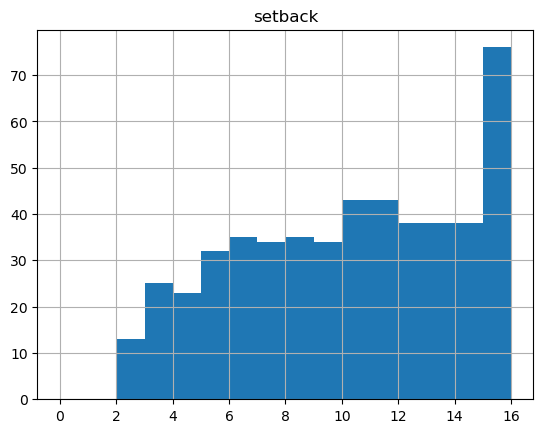

In [121]:
# find realizations and setbacks that have any days or segments below the threshold
any_min_flw = min_flw_df[['r','setback']].drop_duplicates()
# find range of setbacks that generally cause excess flow loss
# any_min_flw.hist('r', bins=range(100))
any_min_flw.hist('setback', bins=range(17))

The histogram of realizations that break the minimum flow threshold per setback is helpful to visualize because it shows that by the 8th setback (1600 m) that 30-40% of the time the minimum flow threshold is broken.

In [50]:
# if we want to get particular we could count the number of days a segment fails and allow for 1 or 2 perhaps?
# but there wouldn't be validation for it except perhaps that research like Kenny's show salmon can survive
# in disconnected pulls for a certain period
# min_flw_df.groupby(['r','setback','seg']).count()

In [ ]:
# fig,ax=plt.subplots(4,3, sharex=True, sharey=True, figsize=(8,8))
# for nf, ft_in in enumerate(ft_plt):
#     for nr, region in enumerate(['local_1','local_2','local_3','regional']):
#         ax_n = ax[nr, nf]
#         f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
#         Q_all = f['array']['all'][:]
#         plt_downstream_loss(Q_all, ft_in, ax=ax_n,setback=5)
#         f.close()


In [122]:
# was using regional and ft_in=2 (large and long) for example plots
region = 'regional'
ft_in = 2

f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
rch_hf_all = f['array']['all'][:]
f.close()

In [123]:
rch_hf_all.shape
# if the in-stream flow becomes zero then remove any recharge from that realization to represent it as a null case
# as it would not be implemented
rch_hf_all_adj = np.copy(rch_hf_all)
rch_hf_all_adj[min_flw_df.r, min_flw_df.setback] = np.nan

In [129]:
# find realization closest to the mean
# diff = rch_hf_all.sum(axis=(2,3)) -np.repeat(np.reshape(rch_hf_all.sum(axis=(2,3)).mean(axis=1),(100,1)), 17, axis=1)
# diff.mean(axis=1).argmin()

In [368]:
diff.shape

(100, 17)

In [ ]:
hf_scale = hf_all.loc['Regional'].multiply(1/hf_all.loc['Regional',0].values, axis=0)
hf_scale.transpose().plot(legend=False)

In [127]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

stats_elements = [
    Line2D([0], [0],color='grey',label='Individual\nRealization'),
#     Line2D([0], [0],color='black',label='5th/95th', linestyle='--'),
    Line2D([0], [0],color='black',label='1.5x Quartile\nRange'),
    Line2D([0], [0],color='tab:blue',label='25th/75th'),
    Line2D([0], [0],color='tab:green',label='Median'),
]


The box extends from the first quartile (Q1) to the third quartile (Q3) of the data, with a line at the median. 
The whiskers extend from the box by 1.5x the inter-quartile range (IQR)  
whis = 1.5
IQR = Q3-Q1
upper whisker =  Q3 + whis\*IQR
lower whisker = Q1 - whis\*IQR


In [128]:
def stats_lines(df, ax):
    """ Dataframe with realization as columns and setbacks as index"""
    # plot quantiles on the line plot
    quart = df.quantile([.25,.75], axis=1)
    quart.transpose().plot(color='tab:blue', ax=ax, legend=False)
    median = df.quantile([.5], axis=1)
    median.transpose().plot(color='tab:green', ax=ax, legend=False)
    # calculate whiskers
    iqr = quart.loc[0.75]-quart.loc[0.25]
    # 1.5 x the whole interquartile range
    whisker = pd.DataFrame(quart.loc[0.75] + iqr*1.5)
    whisker[1] = quart.loc[0.25] - iqr*1.5
    # where whisker is greater than max or min set as max or min
    whisker.loc[whisker[0]>df.max(axis=1), 0] = df.max(axis=1)[whisker[0]>df.max(axis=1)]
    whisker.loc[whisker[1]<df.min(axis=1), 1] = df.min(axis=1)[whisker[1]<df.min(axis=1)]
    whisker.plot(color='black', ax=ax, legend=False)
#     quant = df.quantile([.05,.95], axis=1)
#     quant.transpose().plot(color='black', ax=ax, legend=False, linestyle='--')


<Axes: >

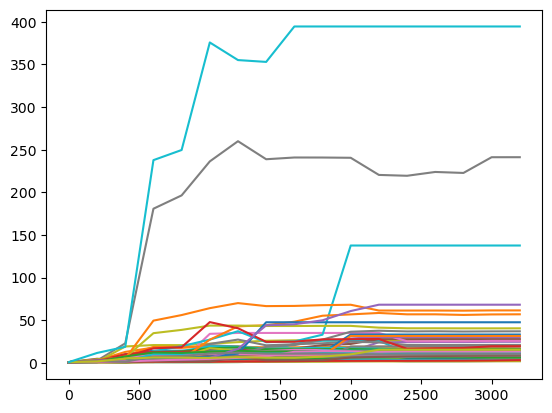

In [308]:
rch_xs_sum = pd.DataFrame(np.sum(rch_hf_all, axis=(2,3)), columns= setbacks).transpose()/1E6
rch_xs_sum.multiply(1/rch_xs_sum.loc[0])

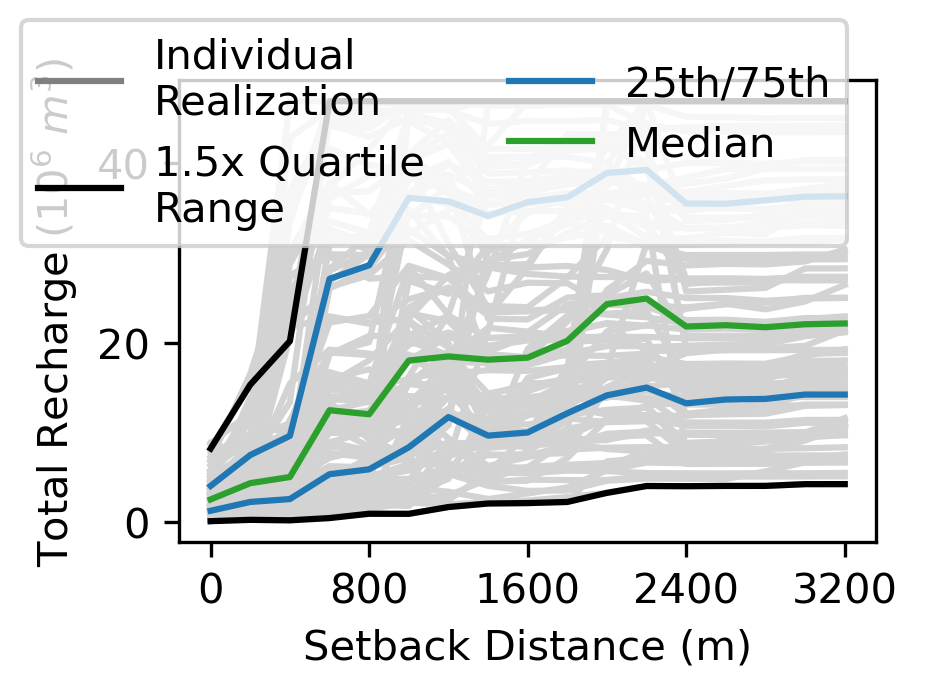

In [334]:
# rch_hf_all resembles the recharge rate for each flow at each setback (including all cells to the stream) for the grid
# so the plot here is the recharge total recharge between the setbacks
# total area within each setback
setback_area = str_setbacks.sum(axis=(1,2))*200*200

def plt_setback_recharge(rch_hf_all, ax):
    # convert from 
    rch_xs_sum = pd.DataFrame(np.sum(rch_hf_all, axis=(2,3)), columns= setbacks).transpose()/1E6
    # scale recharge by the area within the setback to create a benefit-cost ratio
#     rch_xs_sum = rch_xs_sum.multiply(1/setback_area, axis=0)

    rch_xs_sum.plot(legend=False, color='lightgray', ax =ax)
    
    rch_xs_sum_mean = pd.DataFrame(rch_xs_sum.mean(axis=1),columns=['mean'])
#     rch_xs_sum_mean.plot(color='black', ax=ax, legend=False)

    ax.set_xticks(rch_xs_sum.index[::4])
    stats_lines(rch_xs_sum, ax)
    return(rch_xs_sum_mean)

fig, ax = plt.subplots(figsize=(3,2), dpi=300)
rch_xs_sum_mean = plt_setback_recharge(rch_hf_all, ax=ax)
# rch_xs_sum_mean = plt_setback_recharge(rch_hf_all_adj, ax=ax)
ax.set_xlabel('Setback Distance (m)')
ax.set_ylabel('Total Recharge ($10^6$ $m^3$)')
fig.legend(handles=stats_elements, loc= 'outside upper left', ncol=2)


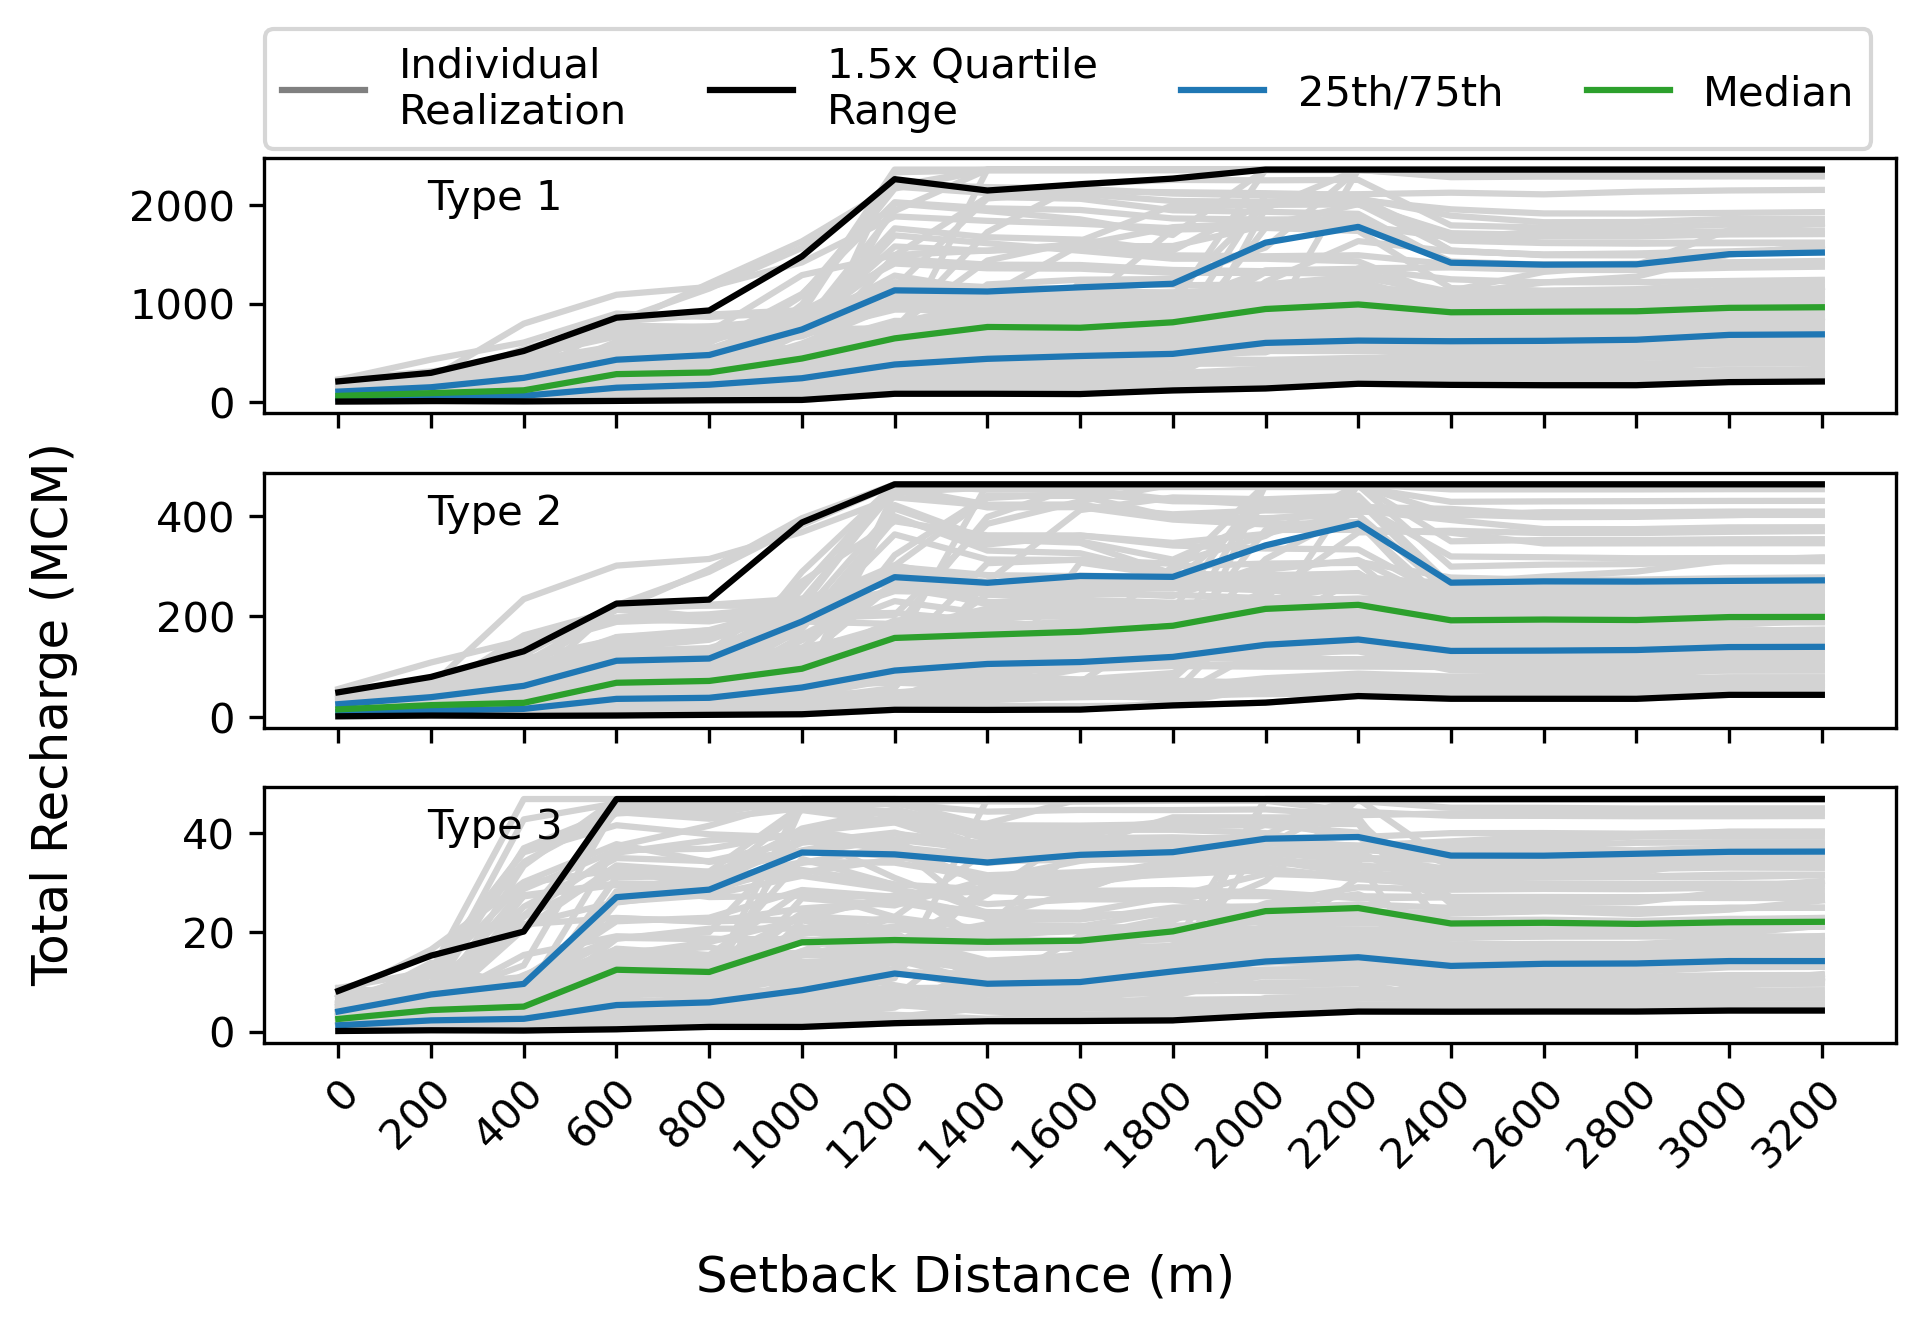

In [336]:
region='regional'
rch_mean_all = pd.DataFrame()
fig,ax=plt.subplots(3,1, sharex='col', sharey=False, figsize=(6.5,4), dpi=300)
for nf, ft_in in enumerate(ft_plt):
        ax_n = ax[nf]
        f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
        rch_hf_all = f['array']['all'][:]
        f.close()
        rch_xs_sum_mean = plt_setback_recharge(rch_hf_all, ax=ax_n)
        # second plot for boxplot
#         ax_n = ax[nf, 1]
#         rch_xs_sum = pd.DataFrame(np.sum(rch_hf_all, axis=(2,3)), columns= setbacks).transpose()/1E6
#         rch_xs_sum.transpose().boxplot(ax=ax_n)

for nf, ft_in in enumerate(ft_plt):
    ax_n = ax[nf]
#     ax_n.set_xlabel('Setback Distance (m)')
    ax_n.annotate('Type '+str(ft_in),xy=(0.1,0.8),xycoords='axes fraction')
    ax_n.set_xticks(rch_xs_sum_mean.index)
    ax_n.set_xticks([], minor=True)
    rot_ticks =  plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# set x labels for boxplots 
# ax_n = ax[-1,1]
# rot_ticks =  plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.supylabel('Total Recharge (MCM)')#, x=-0.01)
# plt.ylabel('Total Recharge ($10^6$ $m^3$)')
fig.supxlabel('Setback Distance (m)')#,y=-0.04)
# ax[0].set

lgd = fig.legend(handles=stats_elements,  loc='center left', bbox_to_anchor=(0.13, 1.02),ncol=4)#loc= 'outside upper center',

fig.tight_layout()
# fig.legend(handles=stats_elements,  loc='upper center', ncol=4)#loc= 'outside upper center',

fig.savefig(join(fig_dir, 'all_recharge_no_boxplot.png'), bbox_inches='tight')


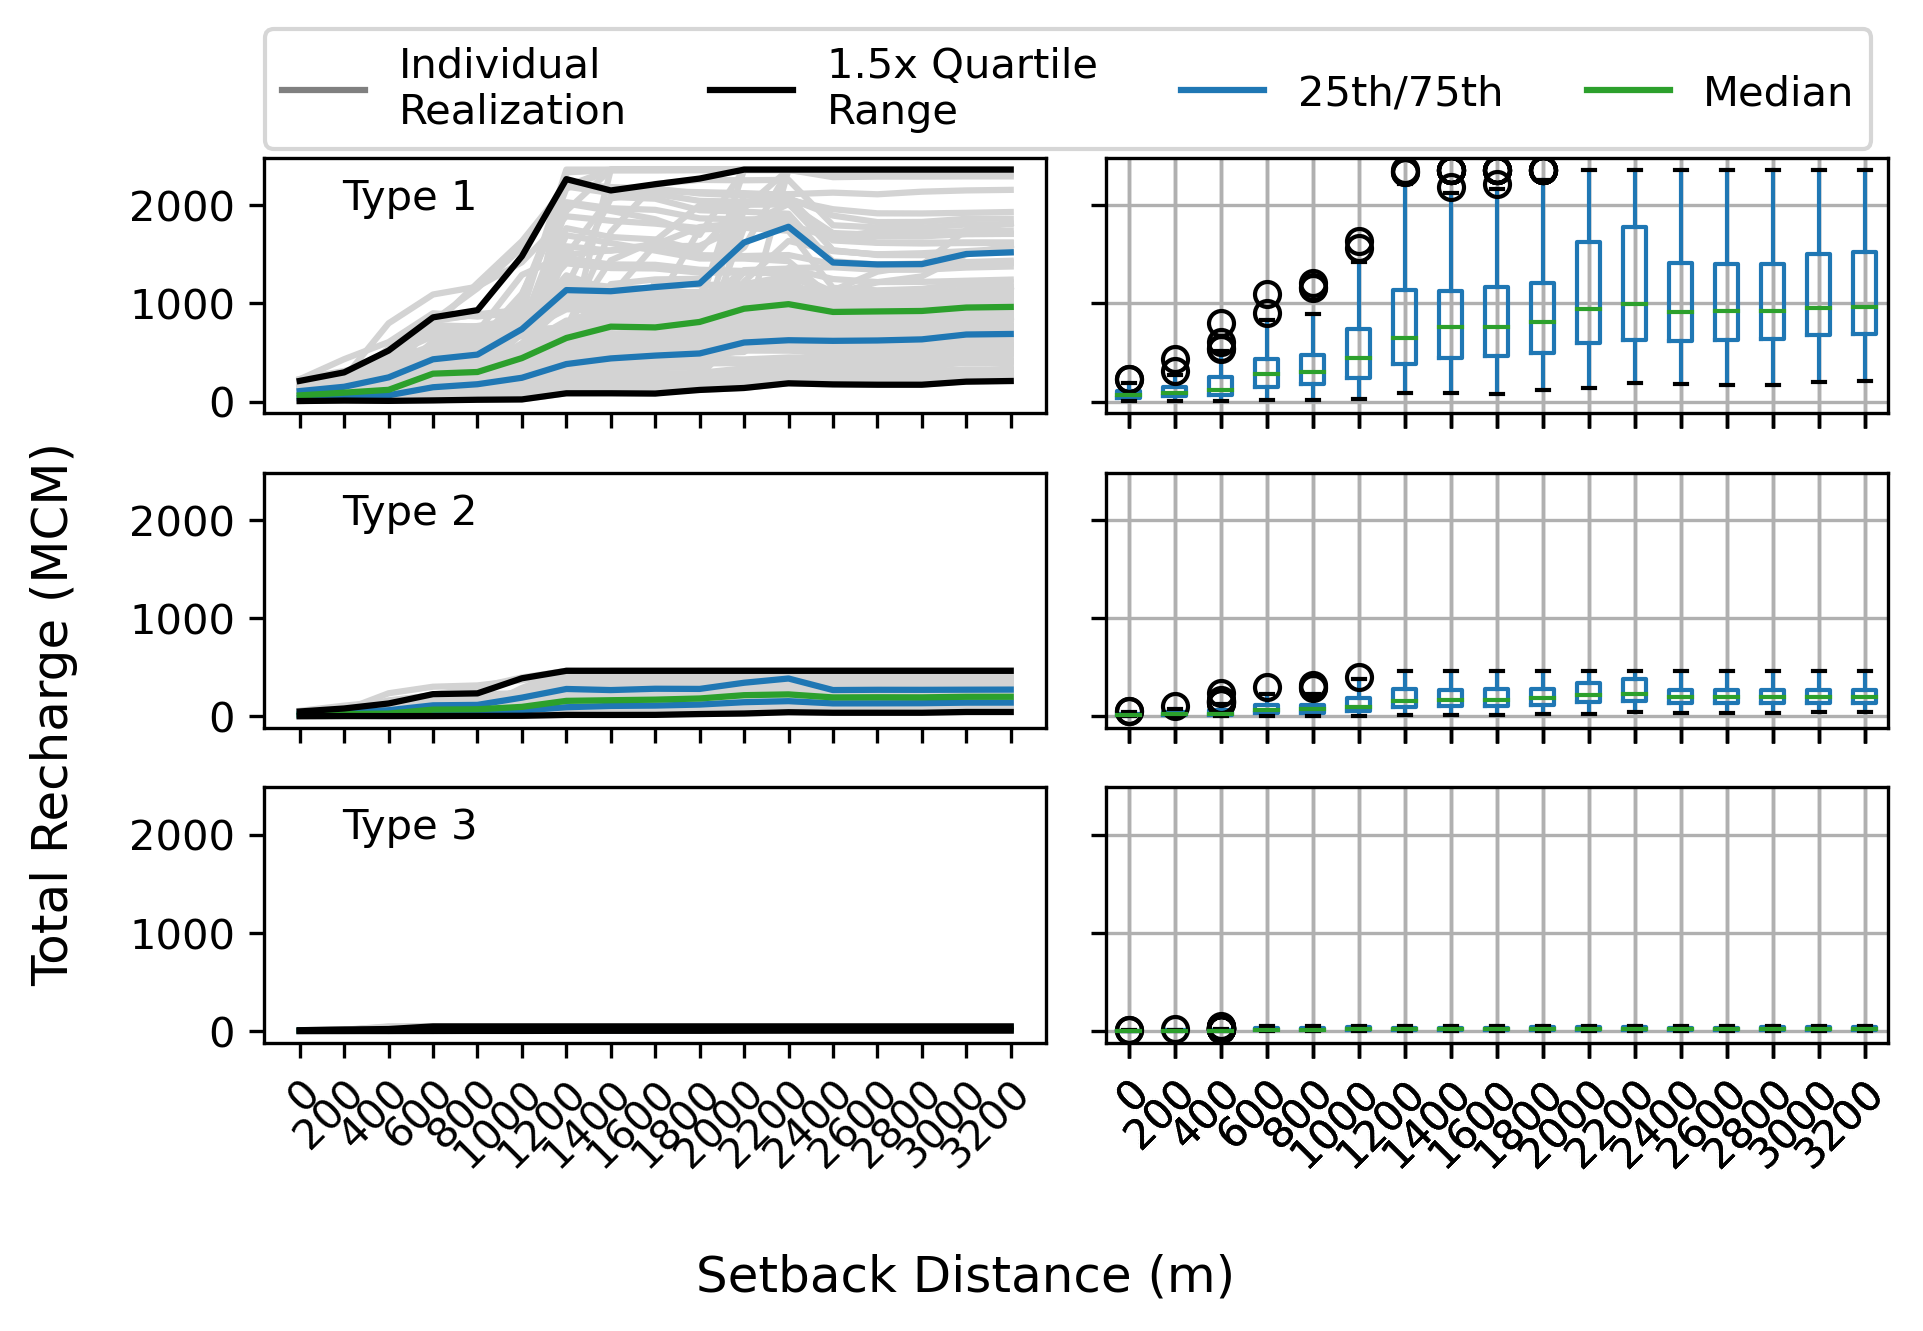

In [198]:
region='regional'
rch_mean_all = pd.DataFrame()
fig,ax=plt.subplots(3,2, sharex='col', sharey=True, figsize=(6.5,4), dpi=300)
for nf, ft_in in enumerate(ft_plt):
        ax_n = ax[nf,0]
        f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
        rch_hf_all = f['array']['all'][:]
        f.close()
        rch_xs_sum_mean = plt_setback_recharge(rch_hf_all, ax=ax_n)
        # second plot for boxplot
        ax_n = ax[nf, 1]
        rch_xs_sum = pd.DataFrame(np.sum(rch_hf_all, axis=(2,3)), columns= setbacks).transpose()/1E6
        rch_xs_sum.transpose().boxplot(ax=ax_n)

for nf, ft_in in enumerate(ft_plt):
    ax_n = ax[nf,0]
#     ax_n.set_xlabel('Setback Distance (m)')
    ax_n.annotate('Type '+str(ft_in),xy=(0.1,0.8),xycoords='axes fraction')
    ax_n.set_xticks(rch_xs_sum_mean.index)
    ax_n.set_xticks([], minor=True)
    rot_ticks =  plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# set x labels for boxplots 
ax_n = ax[-1,1]
rot_ticks =  plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.supylabel('Total Recharge (MCM)')#, x=-0.01)
# plt.ylabel('Total Recharge ($10^6$ $m^3$)')
fig.supxlabel('Setback Distance (m)')#,y=-0.04)
# ax[0].set


# fig.legend(handles=stats_elements,  loc='upper center', ncol=4)#loc= 'outside upper center',
# lgd = fig.legend(handles=stats_elements,  loc=(0.15, .925), ncol=4, mode='horizontal')
# solution was bbox_to_anchor
lgd = fig.legend(handles=stats_elements,  loc='center left', bbox_to_anchor=(0.13, 1.02),ncol=4)

fig.tight_layout()
# fig.legend(handles=stats_elements,  loc='upper center', ncol=4)#loc= 'outside upper center',

fig.savefig(join(fig_dir, 'all_recharge.png'), bbox_inches='tight')


When plotting the recharge as just the number of cells there are less situations where there is a negative slope. I'm not certain, but I must imagine that negative slopes must occur when additional setback opens up upstream recharge that lowers the depth for downstream recharge. Or what might be happening is that when the cross-section is expanded there can be side channel that develop which become the new thalweg so the cells being activated might be confined to a stream cell away from the original main channel and then as you open up the cross-section further there might be additional spots that are accessed.  

In [148]:
# need to resolve why there is a peak between the 1200 - 2000 m range
# is it because those setbacks are ideal for inundating certain area or because flood depth varies
# is there potentially an issue with the calculation somewhere?
# nrow, ncol=(2,2)

# fig,ax = plt.subplots(nrow, ncol, figsize=(8,8), sharex=True, sharey=True)

# for n, s in enumerate(np.arange(1,17,4)):
#     ax_n = ax[int(n/nrow), n%ncol]
#     ax_n.imshow(rch_hf_all[30,n], norm = mpl.colors.LogNorm())
#     ax_n.set_xlim(50,150)
#     ax_n.set_ylim(20,60)
#     ax_n.set_title(setbacks[s])
# # fig.subplots_adjust(hspace=0)                                                                                  
# fig.tight_layout(pad=0.1, w_pad=0.1, h_pad=-20)

In [37]:
# rch_mean_all = pd.DataFrame()
# ft_plt = [1,2,3] #[2,3]
# # fig,ax=plt.subplots(4,3, sharex=True, sharey=True, figsize=(8,8)) 
# fig,ax=plt.subplots(1,3, sharex=True, sharey=True, figsize=(6.5,2), dpi=300)
# for nf, ft_in in enumerate(ft_plt):
# #     for nr, region in enumerate(['local_1','local_2','local_3','regional']):
#     for nr, region in enumerate(['regional']):
# #         ax_n = ax[nr, nf]
#         ax_n = ax[nf]
#         f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
#         rch_hf_all = f['array']['all'][:]
#         f.close()
#         rch_xs_sum_mean = plt_setback_recharge(rch_hf_all, ax=ax_n)
#         rch_xs_sum_mean['region']=region
#         rch_xs_sum_mean['ft'] = ft_in
#         rch_mean_all = pd.concat((rch_mean_all,rch_xs_sum_mean))
# region_names=['Lower','Middle','Upper','Regional']        
# # for nr, region in enumerate(['local_1','local_2','local_3','regional']):
# #     ax[nr,0].set_ylabel(region_names[nr])
# for nf, ft_in in enumerate(ft_plt):
# #     ax_n = ax[nr, nf]
#     ax_n = ax[nf]
#     ax_n.set_xlabel('Setback Distance (m)')
#     ax_n.set_title('Type '+str(ft_in))
#     rot_ticks =  plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# fig.supylabel('Total Recharge ($10^6$ $m^3$)')
# # fig.supxlabel('Setback Distance (m)')
# # ax[0].set


In [72]:
# grad1_df = pd.DataFrame(np.gradient(smooth)[1], columns = np.arange(0,3400,200))

# # grad1_df.iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().plot(legend=False,color='lightgray')
# # grad1_df.iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().mean(axis=1).plot(color='black')
# smooth.diff(axis=1).iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().plot(legend=False,color='lightgray')
# smooth.diff(axis=1).iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().mean(axis=1).plot(color='black')

# plt.xticks(setbacks[1::2])


In [73]:
# # np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# # + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
# def plt_max_gradient(rch_hf_all, ax):
#     rch_xs_sum = pd.DataFrame(np.sum(rch_hf_all, axis=(2,3)), columns= setbacks).transpose()/1E6
#     # smooth across setback distances so the changes in high flow area are less abrupt, makes it easier to find gradients
#     smooth = gaussian_filter1d(rch_xs_sum,2, axis=0)
#     smooth = pd.DataFrame(smooth, index= setbacks)
#     # tranpose to fit format for gradient analysis used previously
#     smooth = smooth.transpose()
#     r_out = np.arange(0,100)
#     # can look at maximum of first derivative, or look where second derivative goes from + to -
#     grad1_df = pd.DataFrame(np.gradient(smooth)[1],  columns = setbacks)
#     grad2_df = pd.DataFrame(np.gradient(grad1_df)[1],  columns = setbacks)
#     # plot difference
#     max_df = pd.DataFrame(np.diff(np.sign(grad2_df)), columns = setbacks[1:])
#     max_df = 1*(max_df==-2)
#     # calculate the number of peak gradients per setback
#     max_df = pd.DataFrame(max_df.loc[r_out].transpose().sum(axis=1), columns=['count'])
#     max_df.plot(kind='bar', legend=False, ax=ax, color='lightgray') #.loc[n]
# #     ax.set_xticks(max_df.loc[r_out].transpose().index[::2].astype(str))
#     return(max_df)

# fig,ax = plt.subplots(figsize=(6,3), dpi=300)
# f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+'regional'+'_type'+str(2)+'.hdf5'), "r")
# rch_hf_all = f['array']['all'][:]
# f.close()
# max_df = plt_max_gradient(rch_hf_all, ax=ax)    
# plt.ylabel('Maximum gradient count\n by realization')
# plt.xlabel('Setback distance (m)')

In [200]:
region='regional'
ft_in=2
f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
Q_all = f['array']['all'][:]
f.close()


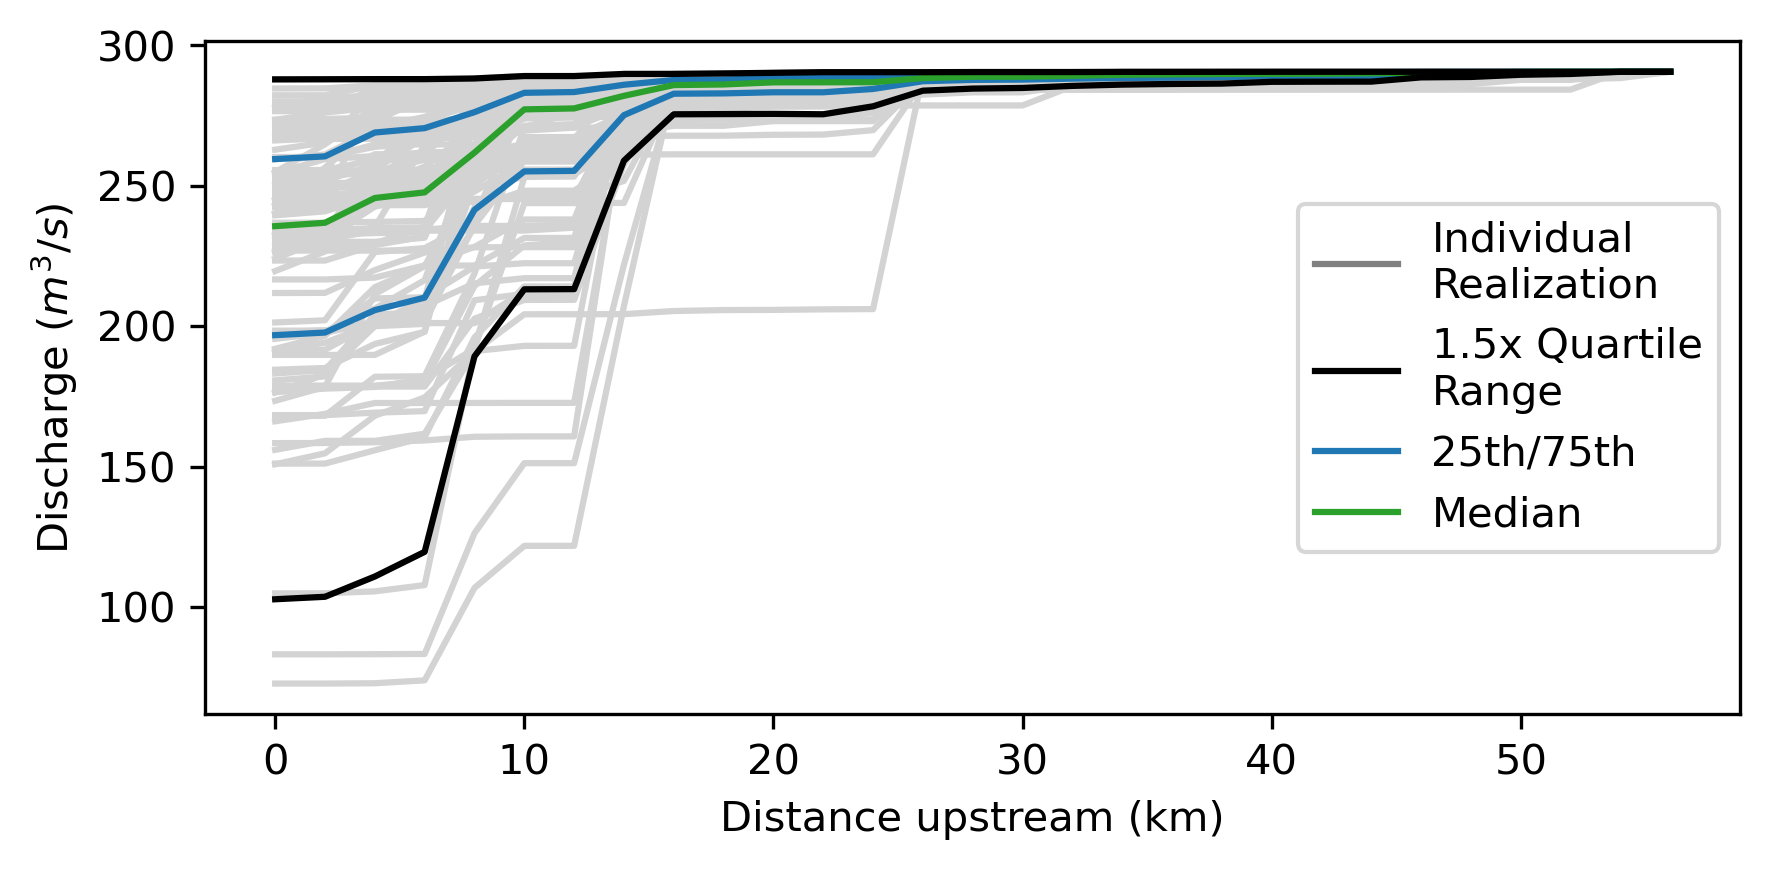

In [201]:
# t=0

def plt_downstream_loss(Q_all, ft_in, ax, setback = -1):
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
    # plot segments in reverse order to align with idea that upstream is east and downstream is west
    Q_plt = pd.DataFrame(Q_all[:,tp_in,setback,:], columns = np.arange(28*2, -2, -2)).transpose()
    Q_plt.plot(color='lightgray', legend=False, ax=ax)
    # plot min, max
#     Q_plt.loc[:,Q_plt.mean(axis=0).isin(Q_plt.mean(axis=0).quantile([0, 1]).values)].plot(legend=False, color='red', ax=ax)

#     Q_plt.mean(axis=1).plot(color='black', label='Averaged Realizations', ax=ax)

    # plot quantiles on the line plot
#     quart = Q_plt.quantile([.25,.75], axis=1)
#     quart.transpose().plot(color='tab:blue', ax=ax, legend=False)
#     median = Q_plt.quantile([.5], axis=1)
#     median.transpose().plot(color='tab:green', ax=ax, legend=False)
#     whisker = (quart-median.values)*1.5 + median.values
#     whisker.transpose().plot(color='black', ax=ax, legend=False)
#     quant = Q_plt.quantile([.05,.95], axis=1)
#     quant.transpose().plot(color='black', ax=ax, legend=False, linestyle='--')
    stats_lines(Q_plt, ax=ax)
    return(Q_plt)
fig,ax = plt.subplots(figsize=(6,3), dpi=300)
Q_plt = plt_downstream_loss(Q_all, ft_in, ax=ax, setback=5)
plt.xlabel('Distance upstream (km)')
plt.ylabel('Discharge ($m^3/s$)')

ax.legend(handles=stats_elements,  loc='center right', ncol=1)#loc= 'outside upper center',

fig.tight_layout()

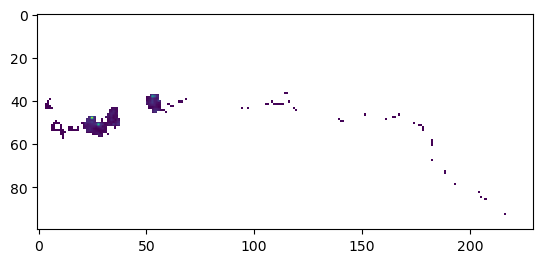

In [202]:
fig,ax_n = plt.subplots()
# Q_all[0 ,:,-1,0]
# # calculate XS recharge 
# Q_diff = np.diff(Q_all, axis=-1)
# # add zero recharge for upstream first XS
# Q_diff = np.append(np.zeros(np.append(Q_all.shape[:3],1)), Q_diff, axis=3)
# Q_diff_plt = plt_downstream_loss(Q_diff, ft_in, ax=ax_n,setback=5)
arr = rch_hf_all[:,5].mean(axis=0)
arr = ma.masked_where(arr==0, arr)
im = ax_n.imshow(arr)
# cbar=plt.colorbar(mappable = im, ax=ax_n,   shrink= 0.7, orientation='horizontal')


Flow reduction mean 18.73 and std dev 12.73
Flow reduction mean 21.83 and std dev 15.00
Flow reduction mean 45.24 and std dev 32.07


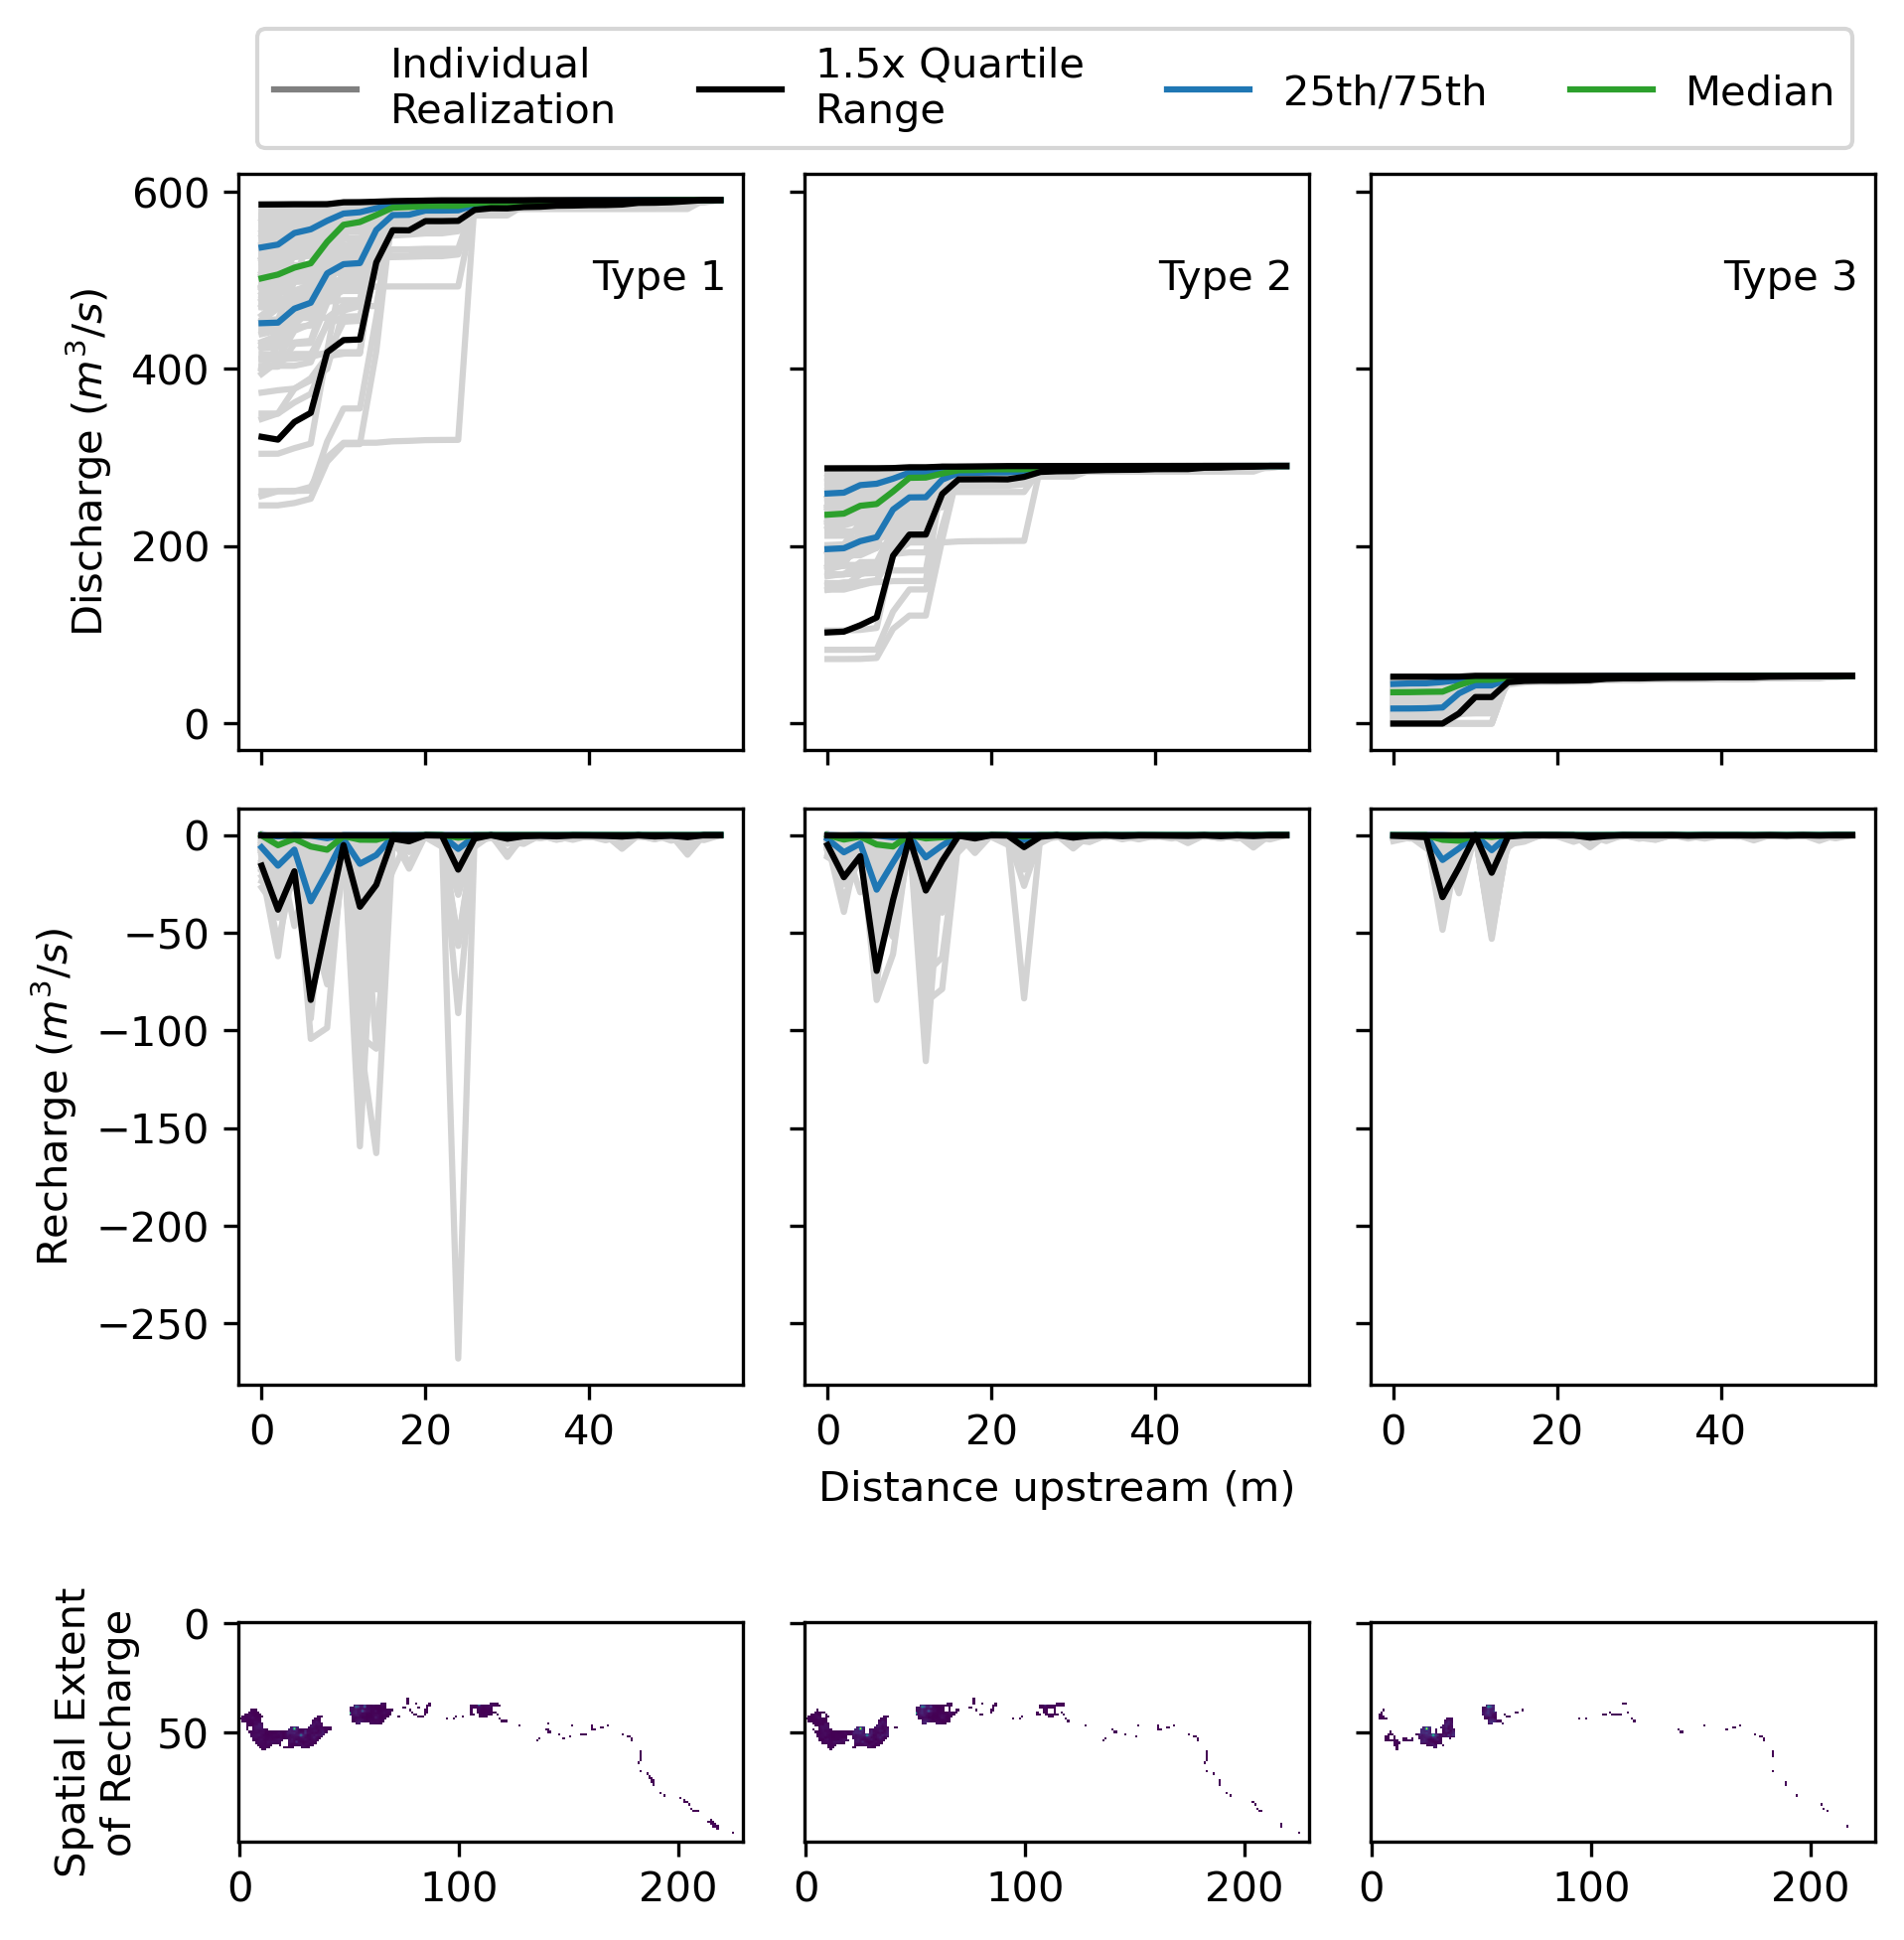

In [247]:
# ft_plt = [1,2,3]
# downside of spatial plots is I can't share the x-axis
fig,ax=plt.subplots(3,3, sharex=False, sharey='row', figsize=(6.5,6.5),dpi=300)
region='regional'
s = 5
for nf, ft_in in enumerate(ft_plt):
    f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    Q_all = f['array']['all'][:]
    f.close()
    ax_d = ax[0, nf]
    plt_downstream_loss(Q_all, ft_in, ax=ax_d,setback=5)
    plt.setp(ax_d, xticklabels=[])
    ax_n = ax[1, nf]
    # calculate XS recharge 
    Q_diff = np.diff(Q_all, axis=-1)
    # add zero recharge for upstream first XS
    Q_diff = np.append(np.zeros(np.append(Q_all.shape[:3],1)), Q_diff, axis=3)
    Q_diff_plt = plt_downstream_loss(Q_diff, ft_in, ax=ax_n,setback=s)
    ax_n = ax[2, nf]
    # spatial view
    f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    rch_hf_all = f['array']['all'][:]
    f.close()
    arr = rch_hf_all[:,s].mean(axis=0)
    arr = ma.masked_where(arr==0, arr)
    im = ax_n.imshow(arr)
    
    ## calculate the percentage reduction in flow by the downstream ##
    # calculate reduction at peak flow for the 1000 m setback
    Q_red = Q_all[:,tp_in,s,-1]/Q_all[:,tp_in,s,0]
    print('Flow reduction mean %.2f' %((1-Q_red).mean()*100), 'and std dev %.2f'%((1-Q_red).std()*100) )
## formatting ##
ax[0,0].set_ylabel('Discharge ($m^3/s$)')
ax[1,0].set_ylabel('Recharge ($m^3/s$)')
ax[2,0].set_ylabel('Spatial Extent\nof Recharge')
# fig.supylabel('Discharge ($m^3/s$)')
# fig.supxlabel('River kilometer')
ax[1,1].set_xlabel('Distance upstream (m)')

for nf, ft_in in enumerate(ft_plt):
    ax_n = ax[0, nf]
    ax_n.annotate('Type '+str(ft_in),xy=(0.7,0.8),xycoords='axes fraction')

# ax[1,2].legend(handles=stats_elements,  loc='lower right', ncol=1)#loc= 'outside upper center',
lgd = fig.legend(handles=stats_elements,  loc='center left', bbox_to_anchor=(0.13, 1.02),ncol=4)

fig.tight_layout()

fig.savefig(join(fig_dir, 'all_flow.png'), bbox_inches='tight')


(54.75581884384155, 32.06520676612854)

# Summary tables

In [205]:
ft_in = 2

T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
p_l_in = flood_type.loc[ft_in,'pk_loc']
tp_in = int(p_l_in*T_in)
# for each setback distance and flood type
# prsent discharge at the downstream end (avg over realizations and use peak flow)
q_avg = Q_all[:,tp_in,s,-1].mean().round(1)
q_std = Q_all[:,tp_in,s,-1].std().round(1)
q_out = str(q_avg)+'±'+ str(q_std)

In [206]:
def format_mean(df):
    df_avg = df.mean().round(1)
    df_std = df.std().round(1)
#     df_out = str(df_avg)+'±'+ str(df_std)
    df_out = str(df_avg)+'\u00B1'+ str(df_std)
    return(df_out)


In [207]:
ft_in=1
f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
rch_hf_all = f['array']['all'][:]
f.close()

In [208]:

s=2
# present mean total recharge and std dev
rch_sum = rch_hf_all[:,s].sum(axis=(1,2))/1E6
format_mean(rch_sum)

'173.3±147.6'

With the +- symbol saving to csv file causes an issue with utf-8 encoding of the csv and adds a symbol. Saving it as a text file doesn't cause an issue and the data can then be pasted into an xlsx to format for the paper. The txt file also writes the fastest.  
The flow differencing has same standard deviation as discharge because it comes from the same data, and it only shows the inverse.  
Flow depth can be back calculated with the discharge saved. Depth might not be a good parameter to plot because there is a big range in cross-section type, although the key reason for depth is to suggest if flow is to shallow rather than too deep so perhaps presenting mean and minimum depth is best.

In [209]:
format_mean(d_all[:2])

'1.9±1.2'

In [300]:
f_csv = open(join(fig_dir, 'summary_table.txt'), 'w', encoding="utf-8")
region='regional'

for nf, ft_in in enumerate(ft_plt):
#     for nr, region in enumerate(['local_1','local_2','local_3','regional']):
#     max_df = max_df_all.loc[(max_df_all.region==region)&(max_df_all.ft==ft_in),'count']
#     max_s = max_df.argmax()
    f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    Q_all = f['array']['all'][:]
    f.close()
    # recharge
    f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    rch_hf_all = f['array']['all'][:]
    f.close()
    f = h5py.File(join(data_dir,'hdf5', 'peak_flow_xs_depth_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    d_all = f['array']['all'][:]
    f.close()
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
#     Q_s = Q_all[:,tp_in, max_s,:].mean(axis=0)
#     d_Q_s = Q_s[0]-Q_s[-1]
    ## output cleaning ##
    for s in np.arange(0,len(setbacks)):
    #     rch_mean =  rch_mean_all.loc[(rch_mean_all.region==region)&(rch_mean_all.ft==ft_in),'mean']
        q_out = format_mean(Q_all[:,tp_in,s,-1])
        rch_out = format_mean(rch_hf_all[:,s].sum(axis=(1,2))/1E6)
#         d = d_all[:,tp_in, s, :-1]
#         d_out = str(d.mean().round(2))+' ('+ str(d.min().round(2))+'-'+ str(d.max().round(2))+')'
        # the min, max, and mean should be taken across the segments then averaged across realizations
        d_mean = d_all[:,tp_in, s, :-1].mean(axis=1).mean()
        d_min = d_all[:,tp_in, s, :-1].min(axis=1).mean()
        d_max = d_all[:,tp_in, s, :-1].max(axis=1).mean()
        d_out = str(d_mean.round(2))+' ('+ str(d_min.round(2))+'-'+ str(d_max.round(2))+')'
        # summarize optimal setback distance with mean recharge and mean flow reduction
        out = ','.join([flood_type.loc[ft_in,'Typology'],
              str(setbacks[s]),  rch_out,
          q_out, d_out, '\n'])
        f_csv.write(out)
#         print( flood_type.loc[ft_in,'Typology'], region_names[nr],
#               setbacks[max_s], '%.0f' %rch_mean.iloc[max_s],'%.0f' %d_Q_s)

f_csv.close()

In [302]:
flood_type

,Typology,cms_pk,cms_mean,v_maf,log_no_d,start_d,cent_d,r_falling,no_pks,no_pks_d,...,sacwy,sjwy,clust,ft,wyr,no_d,perann,wyt,SacInd,pchno
Group.1,,,,,,,,,,,,,,,,,,,,,
1,Very Large,597.485463,86.152610,0.557809,1.954243,114.0,159.0,318.564524,13,0.152318,...,12.10,5.450,2,1,1969.0,90,71.811852,1.0,W,1
2,Large and Long,300.158574,66.468703,0.207648,1.541213,131.5,145.5,138.894133,5,0.143651,...,9.19,3.795,6,2,1951.0,35,37.562852,0.8,NaN,2
3,Long and Late,56.916862,33.277958,0.034314,1.176091,186.0,195.0,10.760402,2,0.166667,...,7.75,3.380,3,3,1956.0,15,13.058792,0.6,BN,4
4,Small and Late,27.297440,26.532885,0.003193,0.301030,165.0,166.0,6.427924,1,0.500000,...,6.65,2.760,4,4,1948.0,2,1.443072,0.4,D,0
5,Small and Early,34.263384,32.663483,0.003094,0.000000,97.0,97.0,15.857434,1,1.000000,...,9.20,3.560,5,5,1958.0,1,1.047386,0.8,D,5
6,Late Peak,72.632712,44.500936,0.013527,0.602060,110.0,111.0,33.980216,1,0.285714,...,8.54,3.550,1,6,1962.5,4,4.563738,0.8,NaN,3


In [299]:
for s in np.arange(0,len(setbacks)):

    d_mean = d_all[:,tp_in, s, :-1].mean(axis=1).mean()
    d_min = d_all[:,tp_in, s, :-1].min(axis=1).mean()
    d_max = d_all[:,tp_in, s, :-1].max(axis=1).mean()
    print('Mean %.2f'%d_mean,'min %.2f'%d_min,'max %.2f'%d_max)

Mean 0.97 min 0.64 max 1.76
Mean 1.08 min 0.44 max 3.15
Mean 1.02 min 0.48 max 3.19
Mean 1.07 min 0.50 max 3.19
Mean 1.05 min 0.44 max 2.79
Mean 1.10 min 0.32 max 2.79
Mean 1.19 min 0.30 max 2.79
Mean 1.27 min 0.29 max 2.79
Mean 1.24 min 0.28 max 2.79
Mean 1.23 min 0.27 max 2.79
Mean 1.23 min 0.22 max 2.79
Mean 1.21 min 0.22 max 2.78
Mean 1.21 min 0.24 max 2.78
Mean 1.21 min 0.24 max 2.78
Mean 1.21 min 0.24 max 2.78
Mean 1.22 min 0.24 max 2.78
Mean 1.23 min 0.24 max 2.88
